In [2]:
import gymnasium as gym
from tetris_gymnasium.envs import Tetris
import numpy as np
import matplotlib.pyplot as plt

In [3]:
env = gym.make("tetris_gymnasium/Tetris")

In [26]:
def TetrisTrain():
    
    alpha = 0.5
    partidas = 100  
    max_pasos_por_partida = 500  
    epsilons = [0, 0.01, 0.3, 0.5, 0.7] 
    
    env = gym.make("tetris_gymnasium/Tetris")
    n_acciones = env.action_space.n
    
    recompensas_acumuladas = np.zeros((len(epsilons), partidas))
    pasos_por_partida = np.zeros((len(epsilons), partidas))
    acciones_seleccionadas = np.zeros((len(epsilons), partidas, n_acciones))
    Qs_por_epsilon = []

    for i, epsilon in enumerate(epsilons):
        print(f"\nEntrenando con epsilon = {epsilon}")
        Q = np.zeros(n_acciones)
        
        for partida in range(partidas):
            acciones_count = np.zeros(n_acciones)
            recompensas_sum = np.zeros(n_acciones) 
            
            obs, info = env.reset()
            recompensa_total = 0
            pasos = 0
            terminado = False
            
            while not terminado and pasos < max_pasos_por_partida:
                if np.random.uniform(0, 1) < epsilon:
                    accion = env.action_space.sample()
                else:
                    if np.all(Q == 0):
                        accion = env.action_space.sample()
                    else:
                        accion = np.argmax(Q)

                obs, recompensa, terminado, truncado, info = env.step(accion)

                if recompensa == 0:
                    recompensa = 0.01
                    
                acciones_count[accion] += 1
                
                Q[accion] += alpha * (recompensa - Q[accion])

                recompensa_total += recompensa
                pasos += 1

                if truncado:
                    terminado = True
            
            recompensas_acumuladas[i, partida] = recompensa_total
            pasos_por_partida[i, partida] = pasos
            acciones_seleccionadas[i, partida] = acciones_count
            
            if (partida + 1) % 20 == 0:
                print(f"  Partida {partida + 1}/{partidas} - "
                      f"Recompensa: {recompensa_total:.2f}, "
                      f"Pasos: {pasos}")
        Qs_por_epsilon.append(Q.copy()) 
    env.close()
    
    return {
        'epsilons': epsilons,
        'recompensas_acumuladas': recompensas_acumuladas,
        'pasos_por_partida': pasos_por_partida,
        'acciones_seleccionadas': acciones_seleccionadas,
        'n_acciones': n_acciones,
        'Qs_por_epsilon': Qs_por_epsilon
    }

In [19]:
def Analisis(resultados):

    epsilons = resultados['epsilons']
    recompensas = resultados['recompensas_acumuladas']
    pasos = resultados['pasos_por_partida']
    acciones = resultados['acciones_seleccionadas']
    n_acciones = resultados['n_acciones']

    print("\n" + "="*60)
    print("RESULTADOS DEL ENTRENAMIENTO")
    print("="*60)
    
    for i, eps in enumerate(epsilons):
        recomp_media = np.mean(recompensas[i])
        recomp_std = np.std(recompensas[i])
        pasos_media = np.mean(pasos[i])
        pasos_std = np.std(pasos[i])
        
        print(f"\nEpsilon = {eps}:")
        print(f"  Recompensa promedio: {recomp_media:.2f} - {recomp_std:.2f}")
        print(f"  Pasos promedio: {pasos_media:.2f} - {pasos_std:.2f}")
        print(f"  Mejor partida: {np.max(recompensas[i]):.2f}")
        print(f"  Peor partida: {np.min(recompensas[i]):.2f}")

    print(f"\n" + "="*40)
    print("ANÁLISIS DE ACCIONES")
    print("="*40)
    
    for i, eps in enumerate(epsilons):
        acciones_totales = np.sum(acciones[i], axis=0)
        acciones_promedio = acciones_totales / len(recompensas[i])
        
        print(f"\nEpsilon = {eps} - Uso promedio de acciones:")
        for j in range(n_acciones):
            porcentaje = (acciones_promedio[j] / np.sum(acciones_promedio)) * 100
            print(f"  Acción {j}: {acciones_promedio[j]:.1f} veces ({porcentaje:.1f}%)")
    
    return recompensas, pasos

In [20]:
def Visualizacion(recompensas, pasos, epsilons):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    
    for i, eps in enumerate(epsilons):
        ax1.plot(recompensas[i], label=f'Eps = {eps}', alpha=0.7)
    ax1.set_xlabel('Partida')
    ax1.set_ylabel('Recompensa Acumulada')
    ax1.set_title('Recompensas por Partida')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    for i, eps in enumerate(epsilons):
        ax2.plot(pasos[i], label=f'Eps = {eps}', alpha=0.7)
    ax2.set_xlabel('Partida')
    ax2.set_ylabel('Pasos por Partida')
    ax2.set_title('Duración de Partidas')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [21]:
print(f"Número de acciones disponibles: {env.action_space.n}")

print("Acciones disponibles:")
actions_obj = env.unwrapped.actions
for attr_name in dir(actions_obj):
    if not attr_name.startswith('_') and hasattr(actions_obj, attr_name):
        action_value = getattr(actions_obj, attr_name)
        if isinstance(action_value, int):
            print(f"  {attr_name}: {action_value}")
print("Recompensas:", env.unwrapped.rewards)

Número de acciones disponibles: 8
Acciones disponibles:
  hard_drop: 5
  move_down: 2
  move_left: 0
  move_right: 1
  no_op: 7
  rotate_clockwise: 3
  rotate_counterclockwise: 4
  swap: 6
Recompensas: RewardsMapping(alife=0.01, clear_line=1, game_over=-2, invalid_action=-0.1)


In [22]:
env.unwrapped.rewards.alife = 0.01
env.unwrapped.rewards.clear_line = 1
env.unwrapped.rewards.game_over = -2
env.unwrapped.rewards.invalid_action = -0.1
print("Recompensas:", env.unwrapped.rewards)

Recompensas: RewardsMapping(alife=0.01, clear_line=1, game_over=-2, invalid_action=-0.1)


Iniciando entrenamiento del agente Tetris con método acción-valor...

Entrenando con epsilon = 0
  Partida 20/100 - Recompensa: -0.92, Pasos: 109
  Partida 40/100 - Recompensa: -0.87, Pasos: 114
  Partida 60/100 - Recompensa: -0.87, Pasos: 114
  Partida 80/100 - Recompensa: -0.94, Pasos: 107
  Partida 100/100 - Recompensa: -0.93, Pasos: 108

Entrenando con epsilon = 0.01
  Partida 20/100 - Recompensa: -1.29, Pasos: 72
  Partida 40/100 - Recompensa: -1.04, Pasos: 97
  Partida 60/100 - Recompensa: -0.94, Pasos: 107
  Partida 80/100 - Recompensa: -1.00, Pasos: 101
  Partida 100/100 - Recompensa: -1.45, Pasos: 56

Entrenando con epsilon = 0.3
  Partida 20/100 - Recompensa: -0.94, Pasos: 107
  Partida 40/100 - Recompensa: -1.61, Pasos: 40
  Partida 60/100 - Recompensa: -1.26, Pasos: 75
  Partida 80/100 - Recompensa: -1.87, Pasos: 14
  Partida 100/100 - Recompensa: -0.92, Pasos: 109

Entrenando con epsilon = 0.5
  Partida 20/100 - Recompensa: -1.81, Pasos: 20
  Partida 40/100 - Recompensa: -

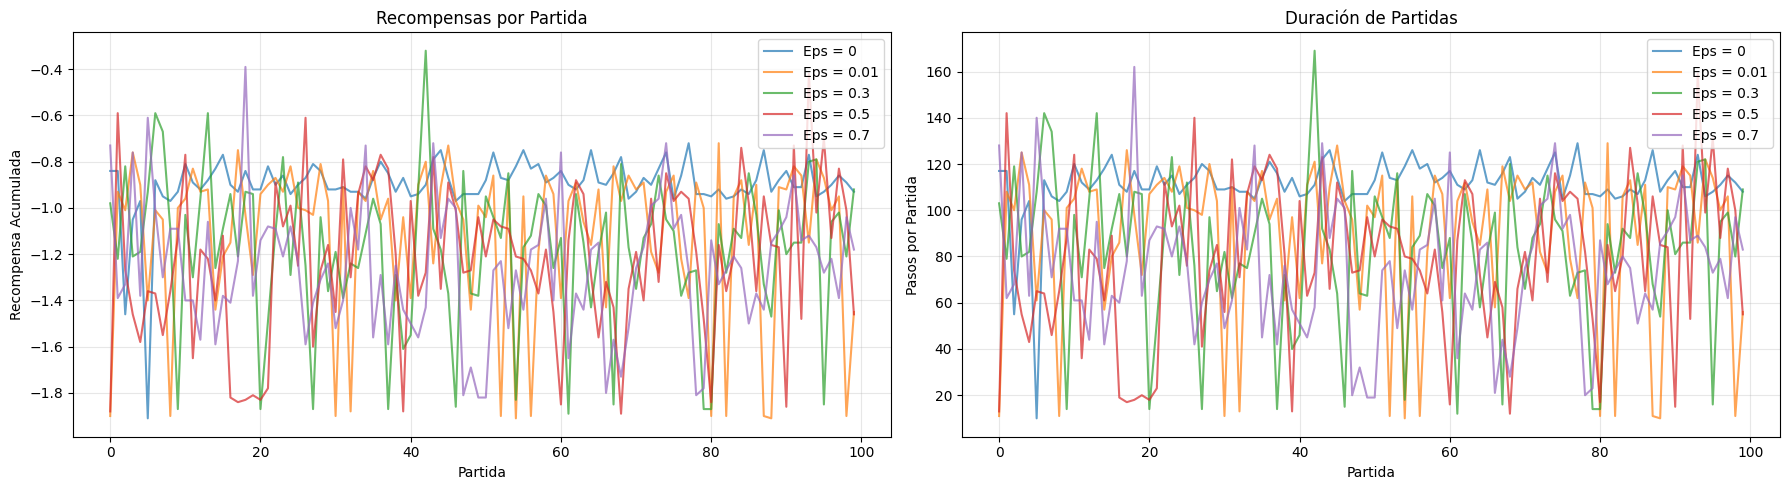


Entrenamiento completado!


In [27]:
print("Iniciando entrenamiento del agente Tetris con método acción-valor...")

resultados = TetrisTrain()
recompensas, pasos = Analisis(resultados)
Visualizacion(recompensas, pasos, resultados['epsilons'])

print("\nEntrenamiento completado!")

In [28]:
resultados['Qs_por_epsilon']

[array([-0.995     , -0.995     , -0.995     , -0.995     , -0.995     ,
        -0.99500977, -0.995     , -0.995     ]),
 array([-0.995     , -0.995     , -0.995     , -0.995     , -0.995     ,
        -0.99524536, -0.995     , -0.995     ]),
 array([ 0.00999617, -0.995     ,  0.00999952,  0.00901855, -0.02140625,
         0.00993866, -0.24125   ,  0.00999233]),
 array([ 0.01      ,  0.01      , -0.995     , -0.4925    ,  0.0098754 ,
         0.01      ,  0.00950928,  0.01      ]),
 array([ 0.01      ,  0.01      , -0.995     ,  0.00999976,  0.00993866,
         0.00214844,  0.01      ,  0.01      ])]

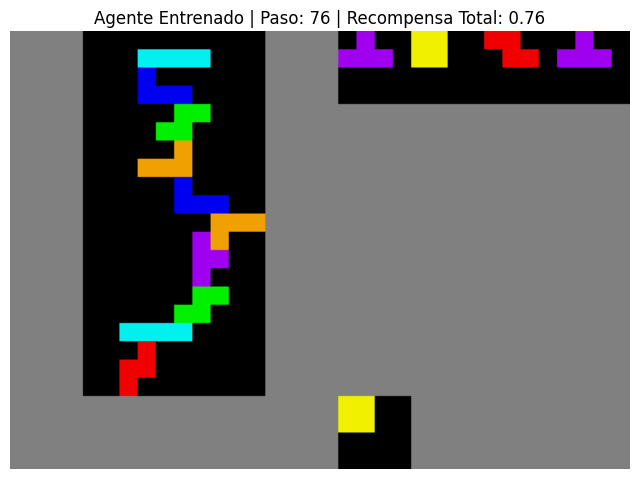

Acción 4 (Exploratoria) - Q values: [ 0.01        0.01       -0.995      -0.4925      0.0098754   0.01
  0.00950928  0.01      ]

¡Juego terminado!
Pasos totales: 77
Recompensa total: -1.24


In [29]:
def VisualizarAgenteEntrenado(Q_table, epsilon_usado=0, max_pasos=500):
    """
    Visualiza un juego usando una tabla Q ya entrenada
    """
    import matplotlib.pyplot as plt
    from IPython.display import clear_output
    import time
    
    env = gym.make("tetris_gymnasium/Tetris", render_mode="rgb_array")
    
    obs, info = env.reset()
    recompensa_total = 0
    pasos = 0
    terminado = False
    
    print(f"Iniciando juego con agente entrenado (epsilon original: {epsilon_usado})")
    print(f"Tabla Q: {Q_table}")
    
    while not terminado and pasos < max_pasos:
        # Renderizar el frame
        frame = env.render()
        
        # Mostrar en matplotlib
        plt.figure(figsize=(8, 10))
        plt.imshow(frame)
        plt.axis('off')
        plt.title(f'Agente Entrenado | Paso: {pasos} | Recompensa Total: {recompensa_total:.2f}')
        
        clear_output(wait=True)
        plt.show()
        
        if np.random.uniform(0, 1) < epsilon_usado:
            accion = env.action_space.sample()
            tipo_accion = "Exploratoria"
        else:
            accion = np.argmax(Q_table)
            tipo_accion = "Greedy"
        
        print(f"Acción {accion} ({tipo_accion}) - Q values: {Q_table}")

        obs, recompensa, terminado, truncado, info = env.step(accion)

        if recompensa == 0:
            recompensa = 0.01
        
        recompensa_total += recompensa
        pasos += 1
        
        if truncado:
            terminado = True
        
        time.sleep(0.3)
    
    print(f"\n¡Juego terminado!")
    print(f"Pasos totales: {pasos}")
    print(f"Recompensa total: {recompensa_total:.2f}")
    
    env.close()
    
    return recompensa_total, pasos

Qs_por_epsilon = resultados['Qs_por_epsilon']
indice_epsilon = 3
epsilon_usado = 0.5

resultado = VisualizarAgenteEntrenado(
    Q_table=Qs_por_epsilon[indice_epsilon], 
    epsilon_usado=epsilon_usado
)